Get the implicit utility function.

In [1]:
struct Calibration
    σ::Float64           # elasticity of relative demand with respect to price         
    γ::Vector{Float64}   # intensity in each good
    ϵ::Vector{Float64}   # elasticity of relative demand with respect to income in luxury good sector
    κ::Vector{Float64}   # For Stone and Geary
    g::Vector{Float64}
end

In [2]:
cal = Calibration(
    0.2,                    # sigma=0.5 completementary goods
    [1/3, 1/3, 1/3],        #intensity
    [0.6, 1.0, 1.65],       #ELASTICITIES
    [0.05, 0.03, 0.02],     #For Stone and Geary
    [1.05, 1.02, 1.01]
)

Calibration(0.2, [0.3333333333333333, 0.3333333333333333, 0.3333333333333333], [0.6, 1.0, 1.65], [0.05, 0.03, 0.02], [1.05, 1.02, 1.01])

In [3]:
ρ=(cal.σ-1)/cal.σ

-4.0

I set initial price vector and time frame at the beginning since it will be the same throughout the setups

In [19]:
p=[5.0, 10.0, 15.0]
C=[5.0, 1.0, 10.0]
T=12

12

# CES utility function

$$E=\sum^{\mathcal{I}}_{i=1}p_iC_i$$

$$C_i^*= \left(\frac{\gamma_i}{p_i}\right)^\sigma \frac{E}{\sum^{\mathcal{I}}_{i=1}\gamma_i^\sigma p_i^{1-\sigma}}$$

$$U(C_1^*,...,C_I^*)=\left[\sum^{\mathcal{I}}_{i=1}\gamma_iC_i^{* \rho} \right]^{\frac{1}{\rho}}

In [5]:
#Function CES
function CES_Utility(C::Vector{Float64}, p::Vector{Float64}; cal=cal)
    #Budget, expenditure function
    E=sum(p[i]*C[i] for i = 1:length(C))
    
    #CONS
    C1=(cal.γ[1]/p[1])^(cal.σ)*E/(sum(cal.γ[i]^cal.σ*p[i]^(1-cal.σ) for i=1:length(cal.γ)))
    C2=(cal.γ[2]/p[2])^(cal.σ)*E/(sum(cal.γ[i]^cal.σ*p[i]^(1-cal.σ) for i=1:length(cal.γ)))
    C3=(cal.γ[3]/p[3])^(cal.σ)*E/(sum(cal.γ[i]^cal.σ*p[i]^(1-cal.σ) for i=1:length(cal.γ)))

    CB=[C1 C2 C3]
    U=sum(cal.γ[i]*CB[i]^ρ for i=1:length(CB))^(1/ρ)


    #SHARE
    ω_p=(p[1]*C1)/E
    ω_n=(p[2]*C2)/E
    ω_l=(p[3]*C3)/E

    return [U, E, C, [C1, C2, C3], [ω_p, ω_n, ω_l]]
end

CES_Utility (generic function with 1 method)

In [6]:
#Insert an Endowment bundle
U=CES_Utility([10.0, 20.0, 5.0],[5.0, 10.0, 15.0])
println("Utility level reached ", U[1])
println("Expenditure/Wealth level ", U[2])
println("Initial Endowment ", U[3])
println("Optimal Endowment given prices ", U[4])
println("Expenditure share per good ", U[5])

Utility level reached 11.028227225054357
Expenditure/Wealth level 325.0
Initial Endowment 

[10.0, 20.0, 5.0]
Optimal Endowment given prices [12.623011705751404, 10.988969950935456, 10.133016130792557]
Expenditure share per good [0.19420018008848314, 0.3381221523364756, 0.4676776675750411]


In [8]:
u=[]
Cendow=[]
Co=[]

scale=10.0
for i = 1:scale
    for j=1:scale
        for k =1:scale
            res =CES_Utility([i,j,k],p)
            u=push!(u,res[1])
            Co=push!(Co, res[4])
            Cendow=push!(Cendow,[i j k])
        end
    end
end

H=[u Cendow Co]

1000×3 Matrix{Any}:
  1.01799  [1.0 1.0 1.0]     [1.1652, 1.01437, 0.935355]
  1.52699  [1.0 1.0 2.0]     [1.7478, 1.52155, 1.40303]
  2.03598  [1.0 1.0 3.0]     [2.3304, 2.02873, 1.87071]
  2.54498  [1.0 1.0 4.0]     [2.913, 2.53592, 2.33839]
  3.05397  [1.0 1.0 5.0]     [3.4956, 3.0431, 2.80607]
  3.56297  [1.0 1.0 6.0]     [4.0782, 3.55028, 3.27374]
  4.07196  [1.0 1.0 7.0]     [4.6608, 4.05747, 3.74142]
  4.58096  [1.0 1.0 8.0]     [5.2434, 4.56465, 4.2091]
  5.08995  [1.0 1.0 9.0]     [5.82601, 5.07183, 4.67678]
  5.59895  [1.0 1.0 10.0]    [6.40861, 5.57902, 5.14445]
  ⋮                          
  6.10794  [10.0 10.0 2.0]   [6.99121, 6.0862, 5.61213]
  6.61694  [10.0 10.0 3.0]   [7.57381, 6.59338, 6.07981]
  7.12593  [10.0 10.0 4.0]   [8.15641, 7.10057, 6.54749]
  7.63493  [10.0 10.0 5.0]   [8.73901, 7.60775, 7.01517]
  8.14392  [10.0 10.0 6.0]   [9.32161, 8.11493, 7.48284]
  8.65292  [10.0 10.0 7.0]   [9.90421, 8.62211, 7.95052]
  9.16191  [10.0 10.0 8.0]   [10.4868, 9.1293, 8.

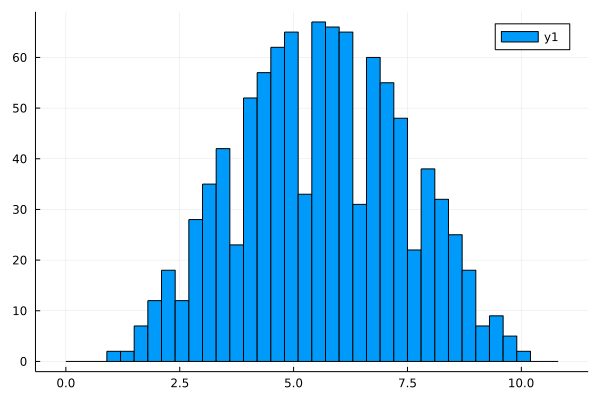

In [10]:
using Plots, Distributions, StatsPlots
histogram(H[:,1]; bins = 0:.3:11)


In [14]:
using DataFrames
function prices(p::Vector{Float64},T::Int64 ;cal=cal)
    #Prices normalized at date t=1
    pp=[p[1]]  #price primary
    pn=[p[2]]  #price normal
    pl=[p[3]]  #price luxury
    #AR(1)
    shock_size=1

    for t=1:T-1
        p_p=p[1]*cal.g[1]^(t)+shock_size*randn() # price dynamics of primary goods
        p_n=p[2]*cal.g[2]^(t)+shock_size*randn() # price dynamics of normal goods
        p_l=p[3]*cal.g[3]^(t)+shock_size*randn()

        pnp=p_p/p_n
        pnl=p_l/p_n

        #for matrix
        pp=push!(pp,p_p)
        pn=push!(pn,p_n)
        pl=push!(pl,p_l)
    end
    return [pp pn pl]
end
ptime=prices(p,T)

data=DataFrame(ptime,:auto)

rename!(data,[:"Primary P",:"Normal P", :"LuxuryP"])

,Primary P,Normal P,LuxuryP
,Float64,Float64,Float64
1,5.0,10.0,15.0
2,6.08202,8.76071,14.143
3,5.49393,11.0889,16.032
4,5.0526,10.4956,15.6689
5,5.00569,10.1412,15.7989
6,6.56152,10.8595,16.5741
7,5.36762,12.1224,15.6184
8,5.92455,11.694,14.1299
9,8.02192,10.6114,15.3546


In [15]:
#Function CES
function CES_UtilityOvertime(C::Vector{Float64}, p::Matrix{Float64}, T::Int64; cal=cal)
    #Budget, expenditure function
    Exp=[]
    Cons=[]
    Share=[]
    Utility=[]

    for t=1:T
        E=sum(p[t,i]*C[i] for i = 1:length(C))
        
        #CONS
        C1=(cal.γ[1]/p[t,1])^(cal.σ)*E/(sum(cal.γ[i]^cal.σ*p[t,i]^(1-cal.σ) for i=1:length(cal.γ)))
        C2=(cal.γ[2]/p[t,2])^(cal.σ)*E/(sum(cal.γ[i]^cal.σ*p[t,i]^(1-cal.σ) for i=1:length(cal.γ)))
        C3=(cal.γ[3]/p[t,3])^(cal.σ)*E/(sum(cal.γ[i]^cal.σ*p[t,i]^(1-cal.σ) for i=1:length(cal.γ)))

        CB=[C1 C2 C3]
        U=sum(cal.γ[i]*CB[i]^ρ for i=1:length(CB))^(1/ρ)


        #SHARE
        ω_p=(p[t,1]*C1)/E
        ω_n=(p[t,2]*C2)/E
        ω_l=(p[t,3]*C3)/E

        ω=[ω_p,ω_n,ω_l]

        Exp=push!(Exp,E)
        Cons=push!(Cons,CB)
        Utility=push!(Utility,U)
        Share=push!(Share, ω)

    end

    return [Utility Exp Cons Share]
end

CES_UtilityOvertime (generic function with 1 method)

In [16]:
V=CES_UtilityOvertime([5.0, 1.0, 10.0], ptime, T)

12×4 Matrix{Any}:
 6.27761  185.0    [7.18541 6.25526 5.76802]  [0.1942, 0.338122, 0.467678]
 6.30526  180.601  [6.90038 6.41467 5.82873]  [0.23238, 0.311167, 0.456453]
 6.20186  198.878  [7.08491 6.15649 5.71891]  [0.195718, 0.343269, 0.461013]
 6.28137  192.448  [7.23068 6.24713 5.76599]  [0.189837, 0.340701, 0.469462]
 6.36443  193.159  [7.32611 6.36133 5.82158]  [0.189856, 0.333984, 0.476161]
 6.24321  209.409  [6.94544 6.27969 5.77051]  [0.217626, 0.325653, 0.456721]
 5.99376  195.144  [6.90001 5.86258 5.57287]  [0.189791, 0.364184, 0.446025]
 5.81972  182.616  [6.5204 5.69132 5.47996]   [0.211539, 0.364448, 0.424012]
 6.05283  204.267  [6.4763 6.1239 5.68767]    [0.254335, 0.318127, 0.427538]
 6.00394  219.218  [6.41272 6.06043 5.65749]  [0.256128, 0.321078, 0.422794]
 6.18148  217.432  [6.58455 6.32197 5.77879]  [0.258907, 0.304676, 0.436417]
 5.73469  228.468  [6.19564 5.66232 5.46343]  [0.244666, 0.350705, 0.404629]

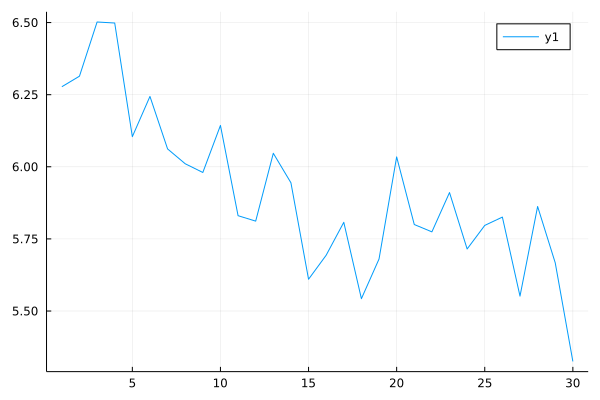

In [38]:
using Plots
#Expenditure / Wealth following fixed endowment
U=V[:,1]
plot(U)

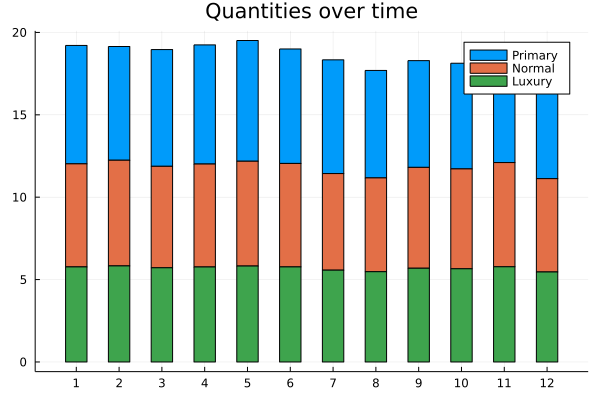

In [20]:
using StatsPlots
Primary=[]
Normal=[]
Luxury=[]
for t=1:T
    p=V[:,3][t][1]
    n=V[:,3][t][2]
    l=V[:,3][t][3]
    Primary=push!(Primary,p)
    Normal=push!(Normal,n)
    Luxury=push!(Luxury,l)
end

ticklabel =[1:T 1:T 1:T]
groupedbar([Primary Normal Luxury],
        title="Quantities over time",
        bar_position = :stack,
        bar_width=0.5,
        xticks=(1:T, ticklabel),
        label=["Primary" "Normal" "Luxury"])

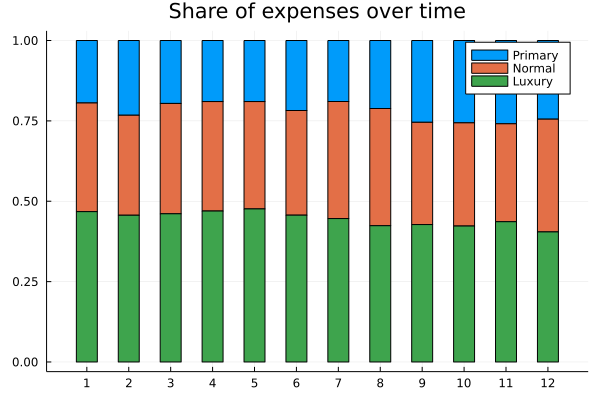

In [21]:
Primary_s=[]
Normal_s=[]
Luxury_s=[]
for t=1:T
    p=V[:,4][t][1]
    n=V[:,4][t][2]
    l=V[:,4][t][3]
    Primary_s=push!(Primary_s,p)
    Normal_s=push!(Normal_s,n)
    Luxury_s=push!(Luxury_s,l)
end

ticklabel =[1:T 1:T 1:T]
groupedbar([Primary_s Normal_s Luxury_s],
        title="Share of expenses over time",
        bar_position = :stack,
        bar_width=0.5,
        xticks=(1:T, ticklabel),
        label=["Primary" "Normal" "Luxury"])

# Stone and Geary

In [7]:
#Function Stone and Geary
function SG(C::Vector{Int64}, cal)
    U=sum(cal.γ[i]*(C[i]+cal.κ[i])^ρ for i=1:length(C))^(1/ρ)
    return U
end

SG (generic function with 1 method)

# Non Homothetic Utility function

In [6]:
function solvingNH(u, C::Vector{Float64}, p::Matrix{Float64}; cal=cal)
    out=[sum(cal.γ[i]^(1/cal.σ)*(C[i]/u^(cal.ϵ[i]))^ρ for i=1:length(C))-1,
        E-sum(p[i]*C[i] for i=1:length(C)),
        u_c1/p[1]=u_c2/p[2],
        u_c1/p[1]=u_c3/p[3],
        u_c2/p[2]=u_c3/p[3]
        ]
    return out
end

solvingNH(1.0,[1.0,2.0,3.0],p)

ErrorException: syntax: misplaced assignment statement in "[(sum((((cal.γ[i] ^ (1 / cal.σ)) * ((C[i] / (u ^ cal.ϵ[i])) ^ ρ)) for i = 1:length(C))) - 1), (E - sum(((p[i] * C[i]) for i = 1:length(C)))), (u_c1 / p[1]) = begin
    # /Users/antoineding/Documents/GitHub/IIRUHH_master/U_find.ipynb, line 4
    (u_c2 / p[2])
end, (u_c1 / p[1]) = begin
    # /Users/antoineding/Documents/GitHub/IIRUHH_master/U_find.ipynb, line 5
    (u_c3 / p[3])
end, (u_c2 / p[2]) = begin
    # /Users/antoineding/Documents/GitHub/IIRUHH_master/U_find.ipynb, line 6
    (u_c3 / p[3])
end]" around /Users/antoineding/Documents/GitHub/IIRUHH_master/U_find.ipynb:2

In [39]:
p=[5.0, 10.0, 15.0]
C=[5.0, 1.0, 10.0]
T=12

12

In [25]:
using NLsolve
function solvingNH(u, C::Vector{Float64}, p::Vector{Float64}; cal=cal)
    out=sum(cal.γ[i]^(1/cal.σ)*(C[i]/u^(cal.ϵ[i]))^ρ for i=1:length(C))-1
    return out
end

nlsolve(u->[solvingNH(u[1], C, p)], [1.0])

Results of Nonlinear Solver Algorithm
 * Algorithm: Trust-region with dogleg and autoscaling
 * Starting Point: [1.0]
 * Zero: [3.9445558862954297]
 * Inf-norm of residuals: 0.000000
 * Iterations: 5
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 6
 * Jacobian Calls (df/dx): 6

In [40]:
using NLsolve

#UTILITY LEVEL for a given C
function solvingNH(u, C::Vector{Float64}, p::Vector{Float64}; cal=cal)
    out=sum(cal.γ[i]^(1/cal.σ)*(C[i]/u^(cal.ϵ[i]))^ρ for i=1:length(C))-1
    return out
end

function NHUtility(C::Vector{Float64}, p::Vector{Float64} ;cal=cal,tol=1e-10,T=100)
    res = nlsolve(u->[solvingNH(u[1], C, p)], [1.0])
    #Utility level for given C
    U=res.zero[1]
    #1st utility for given endowment level
    Uinit=res.zero[1]

    #Wealth and Minimum expenditure for the utility at given endowment level
    E=sum(p[i]*C[i] for i=1:length(C))
    Expmini=sum(cal.γ[i]*U^(cal.ϵ[i]*(1-cal.σ)) * (p[i]^(1-cal.σ)) for i = 1:length(C))^(1/(1-cal.σ))
    
    #Optimal Demand with income effect
    C1=cal.γ[1]*U^(cal.ϵ[1]*(1-cal.σ))  * (p[1]/Expmini)^(-cal.σ)
    C2=cal.γ[2]*U^(cal.ϵ[2]*(1-cal.σ))  * (p[2]/Expmini)^(-cal.σ)
    C3=cal.γ[3]*U^(cal.ϵ[3]*(1-cal.σ))  * (p[3]/Expmini)^(-cal.σ)

    #Expenditure share with income effect
    ω_p=cal.γ[1]*U^(cal.ϵ[1]*(1-cal.σ))  * (p[1]/Expmini)^(1-cal.σ)
    ω_n=cal.γ[2]*U^(cal.ϵ[2]*(1-cal.σ))  * (p[2]/Expmini)^(1-cal.σ)
    ω_l=cal.γ[3]*U^(cal.ϵ[3]*(1-cal.σ))  * (p[3]/Expmini)^(1-cal.σ)

    #Initial Demand for given endowment level, U initial and minimum expenditure level
    Cinit=[C1,C2,C3]
    ω_init=[ω_p, ω_n, ω_l]

    #Optimal update for demand
    C=[C1,C2,C3]
    ω=[ω_p, ω_n, ω_l]

    #Non homothetic preferences updated expenditure since we still have some wealth unused.
    ExpNH=sum(p[i]*C[i] for i=1:length(C))

    #Non homothetic preferences Expenditure have to coincide with the endowment level wealth.
    if abs(E-ExpNH)>tol
        for j=1:T
            res=nlsolve(u->[solvingNH(u[1], C, p)], [1.0])
            U=res.zero[1]
            
            #DEMAND
            C1=cal.γ[1]*U^(cal.ϵ[1]*(1-cal.σ))  * (p[1]/E)^(-cal.σ)
            C2=cal.γ[2]*U^(cal.ϵ[2]*(1-cal.σ))  * (p[2]/E)^(-cal.σ)
            C3=cal.γ[3]*U^(cal.ϵ[3]*(1-cal.σ))  * (p[3]/E)^(-cal.σ)

            #SHARE
            ω_p=cal.γ[1]*U^(cal.ϵ[1]*(1-cal.σ))  * (p[1]/E)^(1-cal.σ)
            ω_n=cal.γ[2]*U^(cal.ϵ[2]*(1-cal.σ))  * (p[2]/E)^(1-cal.σ)
            ω_l=cal.γ[3]*U^(cal.ϵ[3]*(1-cal.σ))  * (p[3]/E)^(1-cal.σ)
            C=[C1, C2, C3]
            ω=[ω_p, ω_n, ω_l]
    
            ExpNH=sum(p[i]*C[i] for i =1:length(C)) 
        end
        return [U, E, ExpNH, C, ω]
    end
end

NHUtility (generic function with 1 method)

In [41]:
NHU=NHUtility(C, p)

5-element Vector{Any}:
   8.618071556611032
 185.0
 184.99999995947806
    [1.9298161478013967, 3.346887908748005, 9.458802675532734]
    [0.052157193183821525, 0.1809128599323246, 0.7669299466648162]

In [29]:
println("NH pref optimal utility level with no waste ", NHU[1])
println("But we have to spend all the wealth so that there is no waste ", NHU[2])
println("Hence NH expenditure will coincide with the wealth ", NHU[3])
println("With bundle (updated) ", NHU[4])
println("Optimal share with no waste ", NHU[5])

NH pref optimal utility level with no waste 8.618071556611032
But we have to spend all the wealth so that there is no waste 185.0
Hence NH expenditure will coincide with the wealth 184.99999995947806
With bundle (updated) [1.9298161478013967, 3.346887908748005, 9.458802675532734]
Optimal share with no waste [0.052157193183821525, 0.1809128599323246, 0.7669299466648162]


In [53]:
u=[]
Cendow=[]
C_w=[]

scale=10.0
for i = 1:scale
    for j=1:scale
        for k =1:scale
            res =NHUtility([i,j,k],p)
            u=push!(u,res[1])
            Cendow=push!(Cendow,[i j k])
            C_w=push!(C_w,res[4])
        end
    end
end

NH=[u Cendow C_w]

1000×3 Matrix{Any}:
  2.3825   [1.0 1.0 1.0]     [0.723576, 0.831627, 1.20439]
  3.2091   [1.0 1.0 2.0]     [0.905297, 1.14453, 1.93521]
  3.94651  [1.0 1.0 3.0]     [1.059, 1.43047, 2.69335]
  4.62276  [1.0 1.0 4.0]     [1.19467, 1.69751, 3.4701]
  5.25333  [1.0 1.0 5.0]     [1.31747, 1.95018, 4.26072]
  5.84795  [1.0 1.0 6.0]     [1.43049, 2.19139, 5.06224]
  6.4132   [1.0 1.0 7.0]     [1.53574, 2.42312, 5.87267]
  6.95383  [1.0 1.0 8.0]     [1.63463, 2.64682, 6.69057]
  7.47339  [1.0 1.0 9.0]     [1.72819, 2.86359, 7.51488]
  7.9746   [1.0 1.0 10.0]    [1.8172, 3.07428, 8.34475]
  ⋮                          
  8.45966  [10.0 10.0 2.0]   [1.90225, 3.27956, 9.17954]
  8.93032  [10.0 10.0 3.0]   [1.98385, 3.48, 10.0187]
  9.38804  [10.0 10.0 4.0]   [2.06236, 3.67606, 10.8618]
  9.83403  [10.0 10.0 5.0]   [2.13812, 3.86813, 11.7085]
 10.2693   [10.0 10.0 6.0]   [2.2114, 4.05653, 12.5585]
 10.6948   [10.0 10.0 7.0]   [2.28242, 4.24156, 13.4115]
 11.1112   [10.0 10.0 8.0]   [2.35138, 4.42

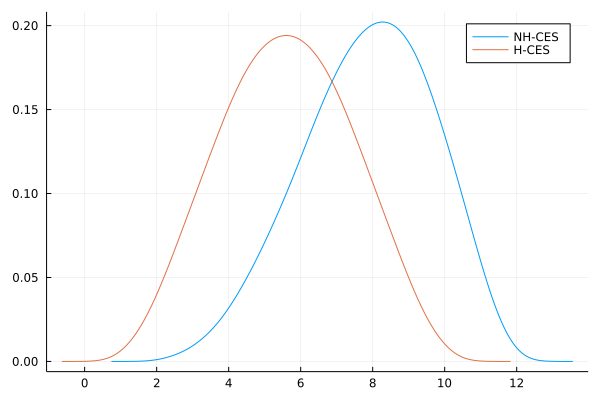

In [31]:
density(NH[:,1], label="NH-CES")
density!(H[:,1], label="H-CES")

In [32]:
#Price dynamics
using Plots, DataFrames
function pricedynamics(p::Vector{Float64}, T::Int64; cal=cal, N=3)
#Time and number of household considered
    #Get our price level dynamics
    shock_size=2
    index=100.0 
    pp=[p[1]]  #price primary
    pn=[p[2]]  #price normal
    pl=[p[3]]  #price luxury
    agg=[1/N*(p[1]+p[2]+p[3])] #aggregate price with homothetic

    for t=1:T-1
        p_p=p[1]*cal.g[1]^(t)+shock_size*randn() # price dynamics of primary goods
        p_n=p[2]*cal.g[2]^(t)+shock_size*randn() # price dynamics of normal goods
        p_l=p[3]*cal.g[3]^(t)+shock_size*randn()
        agg_p=0.333*p_p+0.333*p_n+0.333*p_l #share coming from homothetic consumption bundle

        pp=push!(pp,p_p)
        pn=push!(pn,p_n)
        pl=push!(pl,p_l)
        agg=push!(agg,agg_p)
    end

    pricesplot = [pp pn pl agg]
    return plot(pricesplot, title="Prices dynamics", label=["Primary" "Normal" "Luxury" "Aggregate"], lw=2)
end
    

pricedynamics (generic function with 1 method)

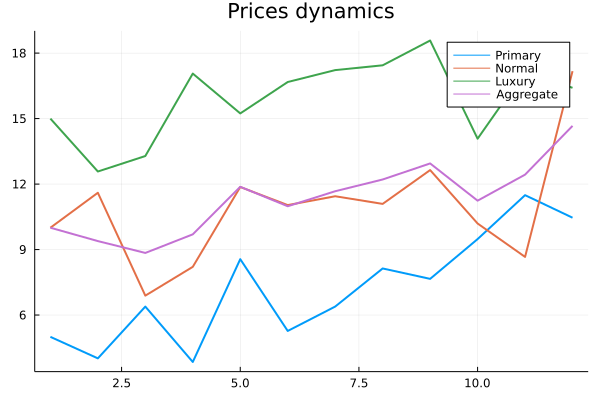

In [42]:
pricedynamics(p,T)

In [43]:
function prices(T::Int64 , p::Vector{Float64};cal=cal)
    #Prices normalized at date t=1
    pp=[p[1]]  #price primary
    pn=[p[2]]  #price normal
    pl=[p[3]]  #price luxury
    #Relative prices
    pnp_r=[1.0]
    pnl_r=[1.0]
    #AR(1)
    shock_size=1

    for t=1:T-1
        p_p=p[1]*cal.g[1]^(t)+shock_size*randn() # price dynamics of primary goods
        p_n=p[2]*cal.g[2]^(t)+shock_size*randn() # price dynamics of normal goods
        p_l=p[3]*cal.g[3]^(t)+shock_size*randn()

        pnp=p_p/p_n
        pnl=p_l/p_n

        #for matrix
        pp=push!(pp,p_p)
        pn=push!(pn,p_n)
        pl=push!(pl,p_l)

        pnp_r=push!(pnp_r,pnp)
        pnl_r=push!(pnl_r,pnl)
        
    end
    return [pp pn pl]
end

ptime=prices(T, p)

data=DataFrame(ptime,:auto)

rename!(data,[:"Primary P",:"Normal P", :"LuxuryP"])

,Primary P,Normal P,LuxuryP
,Float64,Float64,Float64
1,5.0,10.0,15.0
2,5.75597,10.1625,16.8136
3,5.32024,10.168,15.9967
4,3.55175,12.2964,16.1866
5,6.27351,11.6711,16.317
6,7.66185,11.968,14.741
7,6.00129,10.2108,14.7489
8,5.24335,12.0142,15.1248
9,4.55796,11.5951,16.0816


In [44]:
function NHUtilityExp(C::Vector{Float64}, p::Vector{Float64}, E; cal=cal,tol=1e-10,T=100)
    res = nlsolve(u->[solvingNH(u[1], C, p)], [1.0])
    #Utility level for given C
    U=res.zero[1]
    #1st utility for given endowment level
    Uinit=res.zero[1]

    #Minimum expenditure for the utility at given endowment level
    Expmini=sum(cal.γ[i]*U^(cal.ϵ[i]*(1-cal.σ)) * (p[i]^(1-cal.σ)) for i = 1:length(C))^(1/(1-cal.σ))
    
    #Optimal Demand with income effect
    C1=cal.γ[1]*U^(cal.ϵ[1]*(1-cal.σ))  * (p[1]/Expmini)^(-cal.σ)
    C2=cal.γ[2]*U^(cal.ϵ[2]*(1-cal.σ))  * (p[2]/Expmini)^(-cal.σ)
    C3=cal.γ[3]*U^(cal.ϵ[3]*(1-cal.σ))  * (p[3]/Expmini)^(-cal.σ)

    #Expenditure share with income effect
    ω_p=cal.γ[1]*U^(cal.ϵ[1]*(1-cal.σ))  * (p[1]/Expmini)^(1-cal.σ)
    ω_n=cal.γ[2]*U^(cal.ϵ[2]*(1-cal.σ))  * (p[2]/Expmini)^(1-cal.σ)
    ω_l=cal.γ[3]*U^(cal.ϵ[3]*(1-cal.σ))  * (p[3]/Expmini)^(1-cal.σ)

    #Initial Demand for given endowment level, U initial and minimum expenditure level
    Cinit=[C1,C2,C3]
    ω_init=[ω_p, ω_n, ω_l]

    #Optimal update for demand
    C=[C1,C2,C3]
    ω=[ω_p, ω_n, ω_l]

    #Non homothetic preferences updated expenditure since we still have some wealth unused.
    ExpNH=sum(p[i]*C[i] for i=1:length(C))

    #Non homothetic preferences Expenditure have to coincide with the endowment level wealth.
    if abs(E-ExpNH)>tol
        for j=1:T
            res=nlsolve(u->[solvingNH(u[1], C, p)], [1.0])
            U=res.zero[1]
            
            #DEMAND
            C1=cal.γ[1]*U^(cal.ϵ[1]*(1-cal.σ))  * (p[1]/E)^(-cal.σ)
            C2=cal.γ[2]*U^(cal.ϵ[2]*(1-cal.σ))  * (p[2]/E)^(-cal.σ)
            C3=cal.γ[3]*U^(cal.ϵ[3]*(1-cal.σ))  * (p[3]/E)^(-cal.σ)

            #SHARE
            ω_p=cal.γ[1]*U^(cal.ϵ[1]*(1-cal.σ))  * (p[1]/E)^(1-cal.σ)
            ω_n=cal.γ[2]*U^(cal.ϵ[2]*(1-cal.σ))  * (p[2]/E)^(1-cal.σ)
            ω_l=cal.γ[3]*U^(cal.ϵ[3]*(1-cal.σ))  * (p[3]/E)^(1-cal.σ)

            C=[C1, C2, C3]
            ω=[ω_p, ω_n, ω_l]
    
            ExpNH=sum(p[i]*C[i] for i =1:length(C)) 
        end
        return [U, ExpNH, C, ω] #[U, Uinit, miniEforUinit, E,  ExpNH, C, Cinit, ω, ω_init]
    end
end

NHUtilityExp (generic function with 1 method)

In [45]:
function NHUtilitytime(C::Vector{Float64}, p::Matrix{Float64}, T::Int64;cal=cal,tol=1e-10)
    Exp=[]
    miniExp=[]
    Cons=[]
    Share=[]
    NH=[]
    Utility=[]

    #Utility level for given C
    res = nlsolve(u->[solvingNH(u[1], C, p[1,:])], [1.0])
    U=res.zero[1]
    #1st utility for given endowment level
    Uinit=res.zero[1]

    for t=1:T
        #Wealth level
        E=sum(p[t,i]*C[i] for i = 1:length(C))
        
        #Minimum expenditure for the utility at given endowment level
        miniEforUinit=sum(cal.γ[i]*U^(cal.ϵ[i]*(1-cal.σ)) * (p[t,i]^(1-cal.σ)) for i = 1:length(C))^(1/(1-cal.σ))
        
        #Optimal demand with income effect
        c_p=cal.γ[1]*U^(cal.ϵ[1]*(1-cal.σ))  * (p[t,1]/miniEforUinit)^(-cal.σ)
        c_n=cal.γ[2]*U^(cal.ϵ[2]*(1-cal.σ))  * (p[t,2]/miniEforUinit)^(-cal.σ)
        c_l=cal.γ[3]*U^(cal.ϵ[3]*(1-cal.σ))  * (p[t,3]/miniEforUinit)^(-cal.σ)
        
        #Expenditure share with income effect
        ω_p=cal.γ[1]*U^(cal.ϵ[1]*(1-cal.σ))  * (p[t,1]/miniEforUinit)^(1-cal.σ)
        ω_n=cal.γ[2]*U^(cal.ϵ[2]*(1-cal.σ))  * (p[t,2]/miniEforUinit)^(1-cal.σ)
        ω_l=cal.γ[3]*U^(cal.ϵ[3]*(1-cal.σ))  * (p[t,3]/miniEforUinit)^(1-cal.σ)
        
        Consumption=[c_p, c_n, c_l]
        ω=[ω_p, ω_n, ω_l]
    
        price=p[t,:]
        res=nlsolve(u->[solvingNH(u[1], Consumption, price)], [1.0])
        U=res.zero[1]
        NHmax=NHUtilityExp(Consumption, price, E)

        Cons=push!(Cons, Consumption)
        Share=push!(Share, ω)
        Utility=push!(Utility, U)
        Exp=push!(Exp,E)
        miniExp=push!(miniExp,miniEforUinit)
        NH=push!(NH, NHmax)
    end

    #STORE VALUE
    value=[]
    for v=1:4
        for t =1:T
        val=NH[t][v]
        value=push!(value,val)
        end
    end
    NH=(reshape(value,T,4))

    return [Utility Cons Share NH]
end

NHUtilitytime (generic function with 1 method)

In [48]:
ptime

12×3 Matrix{Float64}:
 5.0      10.0     15.0
 5.75597  10.1625  16.8136
 5.32024  10.168   15.9967
 3.55175  12.2964  16.1866
 6.27351  11.6711  16.317
 7.66185  11.968   14.741
 6.00129  10.2108  14.7489
 5.24335  12.0142  15.1248
 4.55796  11.5951  16.0816
 8.17341  10.6004  16.5312
 8.19445  12.5403  17.1041
 8.65213  11.3266  15.9773

In [51]:
u=[]
Cendow=[]
C_w=[]
share=[]

scale=10.0

for i = 1:scale
    for j=1:scale
        for k =1:scale
            res =NHUtilitytime([i,j,k],ptime, T)
            u=push!(u,res[T,4])
            Cendow=push!(Cendow,[i j k])
            C_w=push!(C_w,res[T,6])
            share=push!(share,res[T,7])
        end
    end
end

NHT=[u share C_w]

1000×3 Matrix{Any}:
  2.44191  [0.163708, 0.270225, 0.566067]   [0.680329, 0.857822, 1.2739]
  3.22524  [0.139421, 0.251566, 0.609013]   [0.836861, 1.15345, 1.97956]
  3.93249  [0.123728, 0.237872, 0.6384]     [0.971141, 1.4262, 2.71349]
  4.58572  [0.112485, 0.227157, 0.660359]   [1.09061, 1.68238, 3.46718]
  5.19774  [0.103905, 0.218414, 0.677681]   [1.1993, 1.92572, 4.23581]
  5.77685  [0.0970721, 0.211066, 0.691862]  [1.29969, 2.15867, 5.01631]
  6.3288   [0.091459, 0.204754, 0.703787]   [1.39343, 2.38293, 5.80656]
  6.85779  [0.0867386, 0.199239, 0.714023]  [1.48169, 2.5998, 6.60503]
  7.367    [0.0826951, 0.194355, 0.72295]   [1.56532, 2.81022, 7.41056]
  7.85892  [0.0791795, 0.189981, 0.730839]  [1.64499, 3.01497, 8.22227]
  ⋮                                         
  9.36166  [0.0702785, 0.178335, 0.751386]  [1.88237, 3.64873, 10.8985]
  9.79834  [0.0681023, 0.175353, 0.756545]  [1.94984, 3.83506, 11.7298]
 10.225    [0.0661198, 0.172586, 0.761294]  [2.01518, 4.018, 12.5648]
 

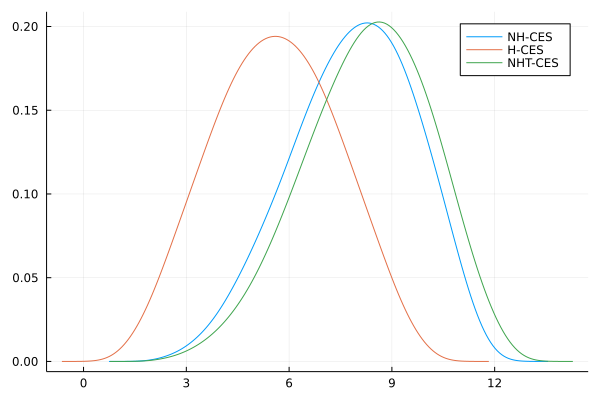

In [55]:
using Plots, Distributions, StatsPlots
density(NH[:,1], label="NH-CES")
density!(H[:,1], label="H-CES")
density!(NHT[:,1], label="NHT-CES")

In [58]:
X=NHUtilitytime([10.0, 10.0, 10.0], ptime, T)

12×7 Matrix{Any}:
 9.27491  [2.04303, 3.6275, 10.651]    …  [0.0413964, 0.15929, 0.799313]
 9.27491  [2.02594, 3.68798, 10.6184]     [0.043033, 0.149456, 0.807511]
 9.27491  [2.04053, 3.65613, 10.6332]     [0.0417422, 0.154611, 0.803647]
 9.27491  [2.22416, 3.53865, 10.665]      [0.0297089, 0.176653, 0.793638]
 9.27491  [1.99351, 3.59118, 10.6938]     [0.0450785, 0.164793, 0.790129]
 9.27491  [1.89281, 3.53108, 10.7847]  …  [0.0539392, 0.173993, 0.772068]
 9.27491  [1.96996, 3.61272, 10.688]      [0.0472162, 0.160788, 0.791995]
 9.27491  [2.04112, 3.52688, 10.7249]     [0.0409341, 0.177009, 0.782056]
 9.27491  [2.1132, 3.57585, 10.6652]      [0.0362441, 0.168904, 0.794851]
 9.27491  [1.89422, 3.66763, 10.6854]     [0.0547623, 0.150701, 0.794537]
 9.27491  [1.91442, 3.58606, 10.7315]  …  [0.0521801, 0.164479, 0.783341]
 9.27491  [1.86889, 3.61183, 10.7361]     [0.0570616, 0.159288, 0.78365]

In [59]:
Umin=X[:,[1,4]];
C=X[:,[2,6]];
Share=X[:,[3,7]];
Exp=X[:,5];

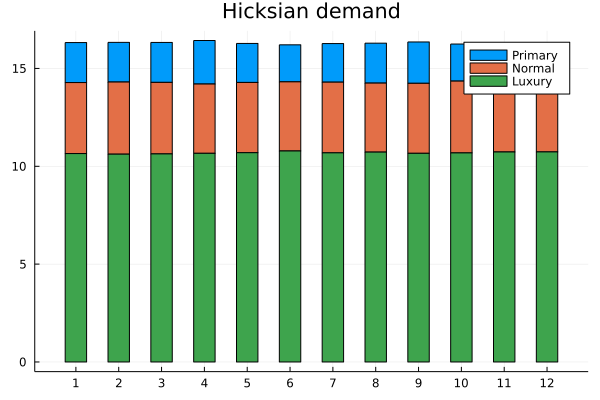

In [69]:
using StatsPlots
Primary=[]
Normal=[]
Luxury=[]
for t=1:T
    p=C[:,1][t][1]
    n=C[:,1][t][2]
    l=C[:,1][t][3]
    Primary_s=push!(Primary,p)
    Normal_s=push!(Normal,n)
    Luxury_s=push!(Luxury,l)
end

ticklabel =[1:T 1:T 1:T]
groupedbar([Primary Normal Luxury],
        bar_position = :stack,
        title="Hicksian demand",
        bar_width=0.5,
        xticks=(1:T, ticklabel),
        label=["Primary" "Normal" "Luxury"])

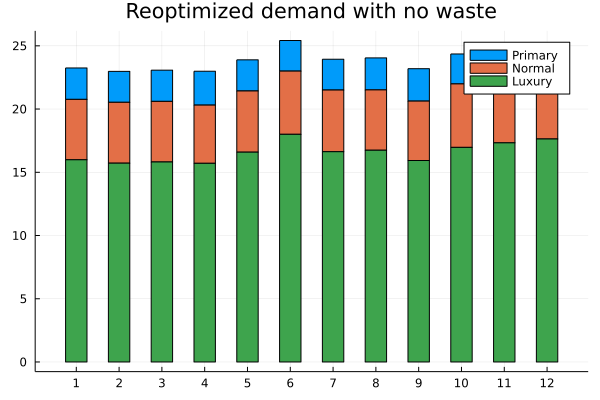

In [70]:
Primary_s=[]
Normal_s=[]
Luxury_s=[]
for t=1:T
    p=C[:,2][t][1]
    n=C[:,2][t][2]
    l=C[:,2][t][3]
    Primary_s=push!(Primary_s,p)
    Normal_s=push!(Normal_s,n)
    Luxury_s=push!(Luxury_s,l)
end

ticklabel =[1:T 1:T 1:T]
groupedbar([Primary_s Normal_s Luxury_s],
        bar_position = :stack,
        title="Reoptimized demand with no waste",
        bar_width=0.5,
        xticks=(1:T, ticklabel),
        label=["Primary" "Normal" "Luxury"])

In [67]:
Share

12×2 Matrix{Any}:
 [0.0495267, 0.175874, 0.774599]  [0.0413964, 0.15929, 0.799313]
 [0.0512191, 0.164618, 0.784163]  [0.043033, 0.149456, 0.807511]
 [0.0497696, 0.17043, 0.779801]   [0.0417422, 0.154611, 0.803647]
 [0.0352595, 0.194215, 0.770526]  [0.0297089, 0.176653, 0.793638]
 [0.0546342, 0.183099, 0.762267]  [0.0450785, 0.164793, 0.790129]
 [0.0672217, 0.195885, 0.736894]  [0.0539392, 0.173993, 0.772068]
 [0.0572935, 0.17877, 0.763936]   [0.0472162, 0.160788, 0.791995]
 [0.049712, 0.196819, 0.753469]   [0.0409341, 0.177009, 0.782056]
 [0.0432685, 0.186257, 0.770474]  [0.0362441, 0.168904, 0.794851]
 [0.0670219, 0.168303, 0.764676]  [0.0547623, 0.150701, 0.794537]
 [0.064238, 0.184146, 0.751616]   [0.0521801, 0.164479, 0.783341]
 [0.07073, 0.178947, 0.750323]    [0.0570616, 0.159288, 0.78365]

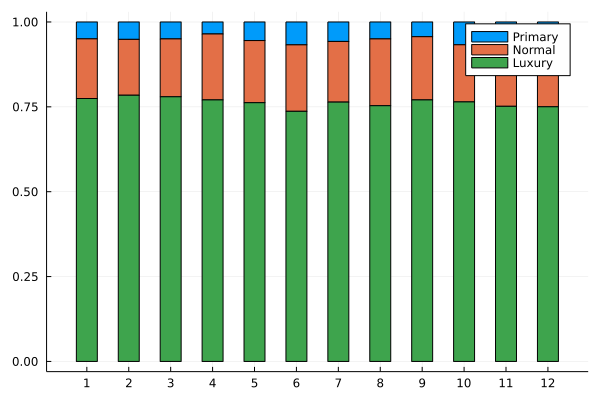

In [65]:
Primary_s=[]
Normal_s=[]
Luxury_s=[]
for t=1:T
    p=Share[:,1][t][1]
    n=Share[:,1][t][2]
    l=Share[:,1][t][3]
    Primary_s=push!(Primary_s,p)
    Normal_s=push!(Normal_s,n)
    Luxury_s=push!(Luxury_s,l)
end

ticklabel =[1:T 1:T 1:T]
groupedbar([Primary_s Normal_s Luxury_s],
        bar_position = :stack,
        bar_width=0.5,
        xticks=(1:T, ticklabel),
        label=["Primary" "Normal" "Luxury"])

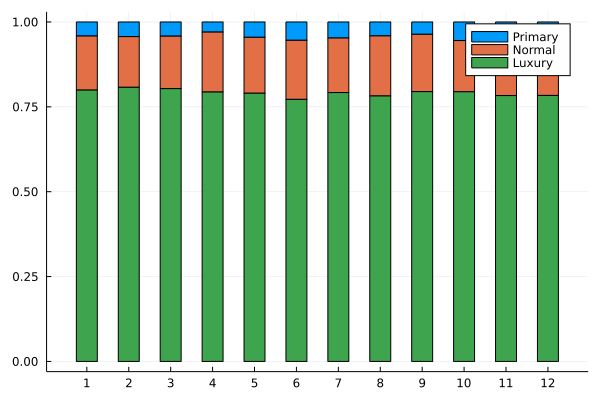

In [66]:
Primary_s=[]
Normal_s=[]
Luxury_s=[]
for t=1:T
    p=Share[:,2][t][1]
    n=Share[:,2][t][2]
    l=Share[:,2][t][3]
    Primary_s=push!(Primary_s,p)
    Normal_s=push!(Normal_s,n)
    Luxury_s=push!(Luxury_s,l)
end

ticklabel =[1:T 1:T 1:T]
groupedbar([Primary_s Normal_s Luxury_s],
        bar_position = :stack,
        bar_width=0.5,
        xticks=(1:T, ticklabel),
        label=["Primary" "Normal" "Luxury"])